
# **<div style="text-align: center; color: blue; font-size: 50px;">Predicting Insurance Claim Outcomes Based on Customer and Vehicle Characteristics</div>**

So here is our second mini project of the ByteWise Data Science fellowship.

In this end-to-end project we will apply all the techniques that we have learned uptil now to create a analyze our data and build a model that can correctly predict the results from the given data. 

We will move step by step from start to end. Here is a complete guide to the project.

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten

---
# **<div style="text-align: center; color: blue; font-size: 50px;">DATASET</div>**

### **Objective**
- The project aims to analyze and predict whether a customer will file an insurance claim based on various factors related to the customer’s demographics, driving experience, vehicle attributes, and history of traffic violations. 
- The objective is to develop a machine learning model that can accurately classify whether an insurance claim will be made ("Claim") or not ("No Claim"), thereby helping insurance companies to assess risk and make informed decisions about policy offerings and premiums.

### **Data Description**
The dataset contains various attributes related to customers and their vehicles, which can be used to predict the likelihood of an insurance claim. Below is a brief description of each feature:
1. `id`: Unique identifier for each record.
2. `age`: Age group of the customer, categorized as "16-25", "26-39", "40-64", and "65+".
3. `gender`: Gender of the customer, either "Male" or "Female".
4. `driving_experience`: The customer’s driving experience, categorized by years of experience such as "0-9y", "10-19y", etc.
5. `education`: The highest level of education attained by the customer, which includes categories like "none", "high school", "university", etc.
6. `income`: The income level of the customer, categorized as "poverty", "working class", "middle class", and "upper class".
7. `credit_score`: A numerical score representing the customer’s creditworthiness.
8. `vehicle_ownership`: Indicates whether the customer owns the vehicle ("Yes") or not ("No").
9. `vehicle_year`: The year of manufacture of the customer’s vehicle, categorized as "before 2015" or "after 2015".
10. `married`: Indicates whether the customer is married ("Yes") or not ("No").
11. `children`: Indicates whether the customer has children ("Yes") or not ("No").
12. `postal_code`: The postal code of the customer’s residence, which could indicate geographic location.
13. `annual_mileage`: The number of miles driven annually by the customer.
14. `vehicle_type`: The type of vehicle owned by the customer, such as "sedan", "sports car", etc.
15. `speeding_violations`: The number of speeding violations recorded for the customer.
16. `duis`: The number of Driving Under the Influence (DUI) incidents recorded for the customer.
17. `past_accidents`: The number of past accidents the customer has been involved in.
18. `outcome`: The target variable, indicating whether the customer made a claim ("Claim") or did not make a claim ("No Claim").

The primary objective of this project is to explore the relationships between the various features and the insurance claim outcome. Using this analysis, machine learning models will be developed to predict the likelihood of a claim being made. The findings will help insurance companies in risk assessment, pricing strategies, and targeted customer interventions.

First step is to import the data and convert it into dataframe.

In [72]:
df = pd.read_csv('/kaggle/input/car-insurance/Car insurance.csv')
df.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,65+,Female,0-9y,high school,upper class,0.629027,Yes,after 2015,No,Yes,10238,12000.0,sedan,0,0,0,No Claim
1,750365,16-25,Male,0-9y,none,poverty,0.357757,No,before 2015,No,No,10238,16000.0,sedan,0,0,0,Claim
2,199901,16-25,Female,0-9y,high school,working class,0.493146,Yes,before 2015,No,No,10238,11000.0,sedan,0,0,0,No Claim
3,478866,16-25,Male,0-9y,university,working class,0.206013,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,No Claim
4,731664,26-39,Male,10-19y,no education,working class,0.388366,Yes,before 2015,No,No,32765,12000.0,sedan,2,0,1,Claim


In [73]:
df['id'].duplicated().sum()

0

All the rows of our dataframe are unique entries where each row represents one person who owns a car insurance from company. We will drop the id column as we will not be needing it.

In [74]:
# Drop the 'id' column as it's not needed for analysis
df.drop(columns=['id'], inplace=True)

In [75]:
df.shape

(10000, 17)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  object 
 1   gender               10000 non-null  object 
 2   driving_experience   10000 non-null  object 
 3   education            10000 non-null  object 
 4   income               10000 non-null  object 
 5   credit_score         9018 non-null   float64
 6   vehicle_ownership    10000 non-null  object 
 7   vehicle_year         10000 non-null  object 
 8   married              10000 non-null  object 
 9   children             10000 non-null  object 
 10  postal_code          10000 non-null  int64  
 11  annual_mileage       9043 non-null   float64
 12  vehicle_type         10000 non-null  object 
 13  speeding_violations  10000 non-null  int64  
 14  duis                 10000 non-null  int64  
 15  past_accidents       10000 non-null  

We can see that we have total 10000  rows and 17 features in our data.
Secondly our data needs cleaning as there are certain anamolies that need correction.
So first we will do data cleaning.

---
# **<div style="text-align: center; color: blue; font-size: 50px;">DATA CLEANING</div>**
- Remove or handle any inconsistencies, missing values, or errors in the data.
- In this section we will bw handling missing values, removing duplicates, correcting data types, and dealing with outliers.

Frst we need to get an idea of which columns are numerical and which columns are categorical, the colunms like postal code, accidents, mileage seem to be numerical but we need to check whether they contain descrete values or categories. For this we will count the unique values in each column.

In [334]:
columns = [ 'postal_code', 'annual_mileage', 'speeding_violations', 'duis', 'past_accidents', 'vehicle_type']

for col in columns:
    print(f'\n{df[col].value_counts()}')


postal_code
0    6940
2    2456
3     484
1     120
Name: count, dtype: int64

annual_mileage
-0.250000    1322
 0.000000    1291
 0.250000    1205
-0.500000    1098
 0.500000     946
             ... 
-0.382283       1
 0.232051       1
 0.326505       1
-0.267767       1
 0.277049       1
Name: count, Length: 130, dtype: int64

speeding_violations
0     5028
1     1544
2     1161
3      830
4      530
5      319
6      188
7      140
8       75
10      50
9       49
11      30
12      20
13      12
15       8
14       5
16       4
17       3
19       2
18       1
20       1
Name: count, dtype: int64

duis
0    8118
1    1470
2     331
3      68
4      10
5       2
6       1
Name: count, dtype: int64

past_accidents
0     5584
1     1783
2     1104
3      646
4      366
5      232
6      144
7       61
8       41
9       19
10       9
11       7
12       2
13       1
14       1
Name: count, dtype: int64

vehicle_type
0    9523
1     477
Name: count, dtype: int64


The column like postal code and vehicle type seem to be categorical while other are numerical columns.

### **CATEGORICAL COLUMNS**
From the above output we can see that the categorical columns are: 
1. Age
2. Gender
3. Driving Experince
4. Education
5. Income
6. Vehicle Ownership
7. Vehicle_Year
8. Married
9. Children
10. Postal_Code
11. Vehicle Type
12. Outcome

### **NUMERICAL COLUMNS**
While we have only two numerical columns that are:
1. Credit_Score
2. Annual_Mileage
3. Speeding_Violations
4. Duis
15. Past_Accidents

## **1. DATATYPE CORRECTION**
First step is to corrext the datatypes of the column. Ideally every categorical column should hav datatype category while every numerical column should have data
type int or float.

Here is the code to do that:


In [83]:
categories = ['age', 'gender', 'driving_experience', 'education', 'income', 'vehicle_ownership', 'vehicle_year', 'married', 
              'children', 'postal_code', 'vehicle_type', 'outcome']

for column in categories:
    df[column] = df[column].astype('category')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  10000 non-null  category
 1   gender               10000 non-null  category
 2   driving_experience   10000 non-null  category
 3   education            10000 non-null  category
 4   income               10000 non-null  category
 5   credit_score         9018 non-null   float64 
 6   vehicle_ownership    10000 non-null  category
 7   vehicle_year         10000 non-null  category
 8   married              10000 non-null  category
 9   children             10000 non-null  category
 10  postal_code          10000 non-null  category
 11  annual_mileage       9043 non-null   float64 
 12  vehicle_type         10000 non-null  category
 13  speeding_violations  10000 non-null  int64   
 14  duis                 10000 non-null  int64   
 15  past_accidents      

Now we can see that we have corrected the data types of all the features in our dataframe.

The numerical columns already had correct datatypes, so no need to fi those.

Now we can see that we hhave some missing values in the data we wil also fix them.

But before that we need to xhecck the category columns and see if there are right categories in the columns or not.

## **CHECKING THE CATEGORIES**
We will check the categories of each column and fix them if they have any issue.

In [85]:
df.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,65+,Female,0-9y,high school,upper class,0.629027,Yes,after 2015,No,Yes,10238,12000.0,sedan,0,0,0,No Claim
1,16-25,Male,0-9y,none,poverty,0.357757,No,before 2015,No,No,10238,16000.0,sedan,0,0,0,Claim
2,16-25,Female,0-9y,high school,working class,0.493146,Yes,before 2015,No,No,10238,11000.0,sedan,0,0,0,No Claim
3,16-25,Male,0-9y,university,working class,0.206013,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,No Claim
4,26-39,Male,10-19y,no education,working class,0.388366,Yes,before 2015,No,No,32765,12000.0,sedan,2,0,1,Claim


In [86]:
columns = ['age', 'gender', 'driving_experience', 'education', 'income', 'vehicle_ownership', 'vehicle_year', 'married', 'children', 'postal_code', 'vehicle_type', 'outcome']
for col in columns:
    print(f'\n{df[col].value_counts()}')


age
26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: count, dtype: int64

gender
Female    5010
Male      4990
Name: count, dtype: int64

driving_experience
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64

education
high school     4157
university      3928
none             958
no education     957
Name: count, dtype: int64

income
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64

vehicle_ownership
Yes    6970
No     3030
Name: count, dtype: int64

vehicle_year
before 2015    6967
after 2015     3033
Name: count, dtype: int64

married
No     5018
Yes    4982
Name: count, dtype: int64

children
Yes    6888
No     3112
Name: count, dtype: int64

postal_code
10238    6940
32765    2456
92101     484
21217     120
Name: count, dtype: int64

vehicle_type
sedan         9523
sports car     477
Name: count, dtype: int64

outcome
No Claim    6867
Claim       3133
Name: count, dty

In the column education there is an issue. We have four categories while the category none and no education should be treted as one category because they belong to same category.

In [87]:
df['education'] = df['education'].replace({'none': 'no education'})

/tmp/ipykernel_33/544202751.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['education'] = df['education'].replace({'none': 'no education'})


In [88]:
df['education'].value_counts()

education
high school     4157
university      3928
no education    1915
Name: count, dtype: int64

Now the education column has been rectified. Now we will impute the missing values from our dataframe.

## **2. IMPUTE MISSING VALUES**
Now we will impute the missing values from our columns.

First let's see how many missing values do we have in our dataframe.

In [89]:
df.isnull().sum()

age                      0
gender                   0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
duis                     0
past_accidents           0
outcome                  0
dtype: int64

So credit_score and annua_mileage hav around 1000 rows that have missing entries. We will try to impute it while preserving the actual distribution of the data.

In [90]:
original_columns = df[['credit_score', 'annual_mileage']]

In [91]:
columns_to_impute = ['credit_score', 'annual_mileage']
knn = KNNImputer(n_neighbors = 3, weights = 'distance')
df[columns_to_impute] = knn.fit_transform(df[columns_to_impute])

In [92]:
df.isnull().sum()

age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
vehicle_type           0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
dtype: int64

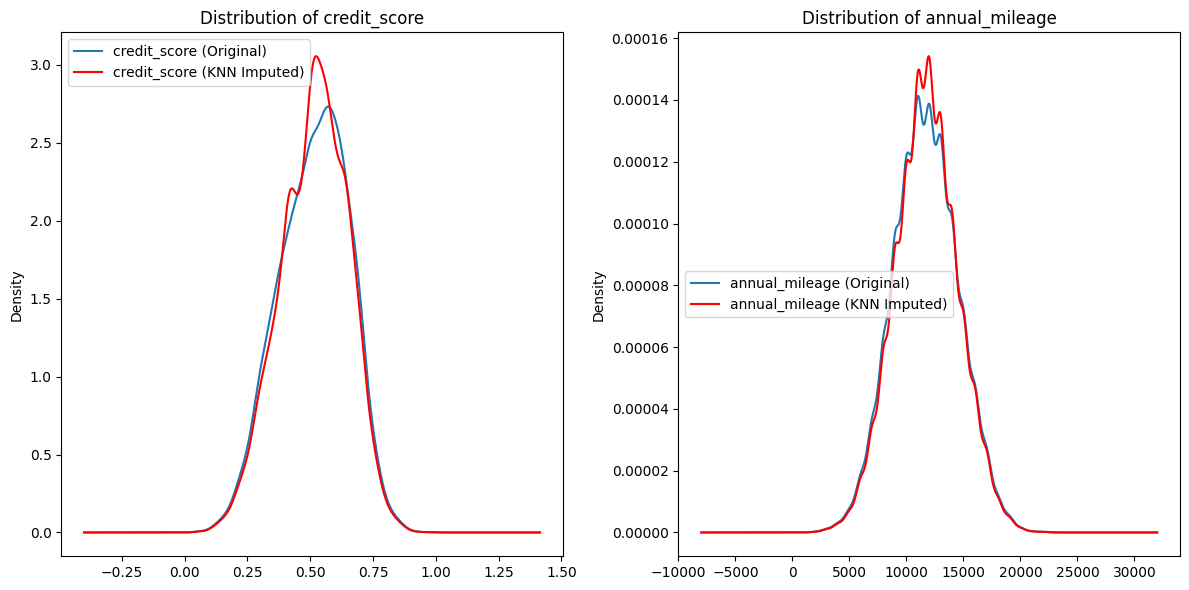

In [93]:
# Create a figure with a grid of subplots (1 row, 2 columns)
# Create a figure with a grid of subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#plt.figure(figsize = (12, 6))
# Flatten the axes array for easy indexing
axs = axs.flatten()

# Plotting each column in its respective subplot
for i in range(2):
    plt.subplot(1, 2, i+1)
    col = columns_to_impute[i]
    ax = axs[i]
    original_columns[col].plot(kind='kde', ax=ax, label=f'{col} (Original)')
    df[col].plot(kind='kde', ax=ax, color='red', label=f'{col} (KNN Imputed)')
    ax.set_title(f'Distribution of {col}')
    ax.legend(loc='best')

# Remove the unused subplot
#fig.delaxes(axs[-1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


So as we can see that the distribution of data has a slight change after the imputaion using KNN Imputaion. and all the missing values have been removed from the dataframe.

Here is the final Dataframe.

In [94]:
df.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,65+,Female,0-9y,high school,upper class,0.629027,Yes,after 2015,No,Yes,10238,12000.0,sedan,0,0,0,No Claim
1,16-25,Male,0-9y,no education,poverty,0.357757,No,before 2015,No,No,10238,16000.0,sedan,0,0,0,Claim
2,16-25,Female,0-9y,high school,working class,0.493146,Yes,before 2015,No,No,10238,11000.0,sedan,0,0,0,No Claim
3,16-25,Male,0-9y,university,working class,0.206013,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,No Claim
4,26-39,Male,10-19y,no education,working class,0.388366,Yes,before 2015,No,No,32765,12000.0,sedan,2,0,1,Claim


Now we are done with the data cleaning of our data. We will now move towards the data analysis phase in which we will try to see different trends in our data.

---
# **<div style="text-align: center; color: blue; font-size: 50px;">EXPLORATORY DATA ANALYSIS</div>**
In this exploratory data analysis (EDA) of the car insurance dataframe, we aim to uncover insightful patterns, trends, and anomalies within the dataset. This dataset encompasses various attributes related to car insurance claims, such as policyholder demographics, vehicle details, claim history, and financial metrics. Through EDA, we will systematically investigate the data's distribution, identify relationships between different features, and highlight potential factors influencing insurance claims. Our goal is to generate a comprehensive understanding of the data, which will inform further analysis and guide decision-making for modeling and predictions. By employing statistical summaries, visualizations, and correlation analyses, we seek to uncover underlying insights that can drive actionable strategies and improve the overall effectiveness of car insurance processes.

## **Count Plots of Categorical Column**
First we make a count plot of all the featres to see the trend of people who calim for the insurance and customers who doesnot claim for the insurance.

In [95]:
columns_to_plot = [
    'age', 'gender', 'driving_experience', 'education', 'income',
    'vehicle_ownership', 'vehicle_year', 'married', 'children',
    'postal_code', 'vehicle_type', 'speeding_violations', 'duis',
    'past_accidents', 'outcome'
]

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


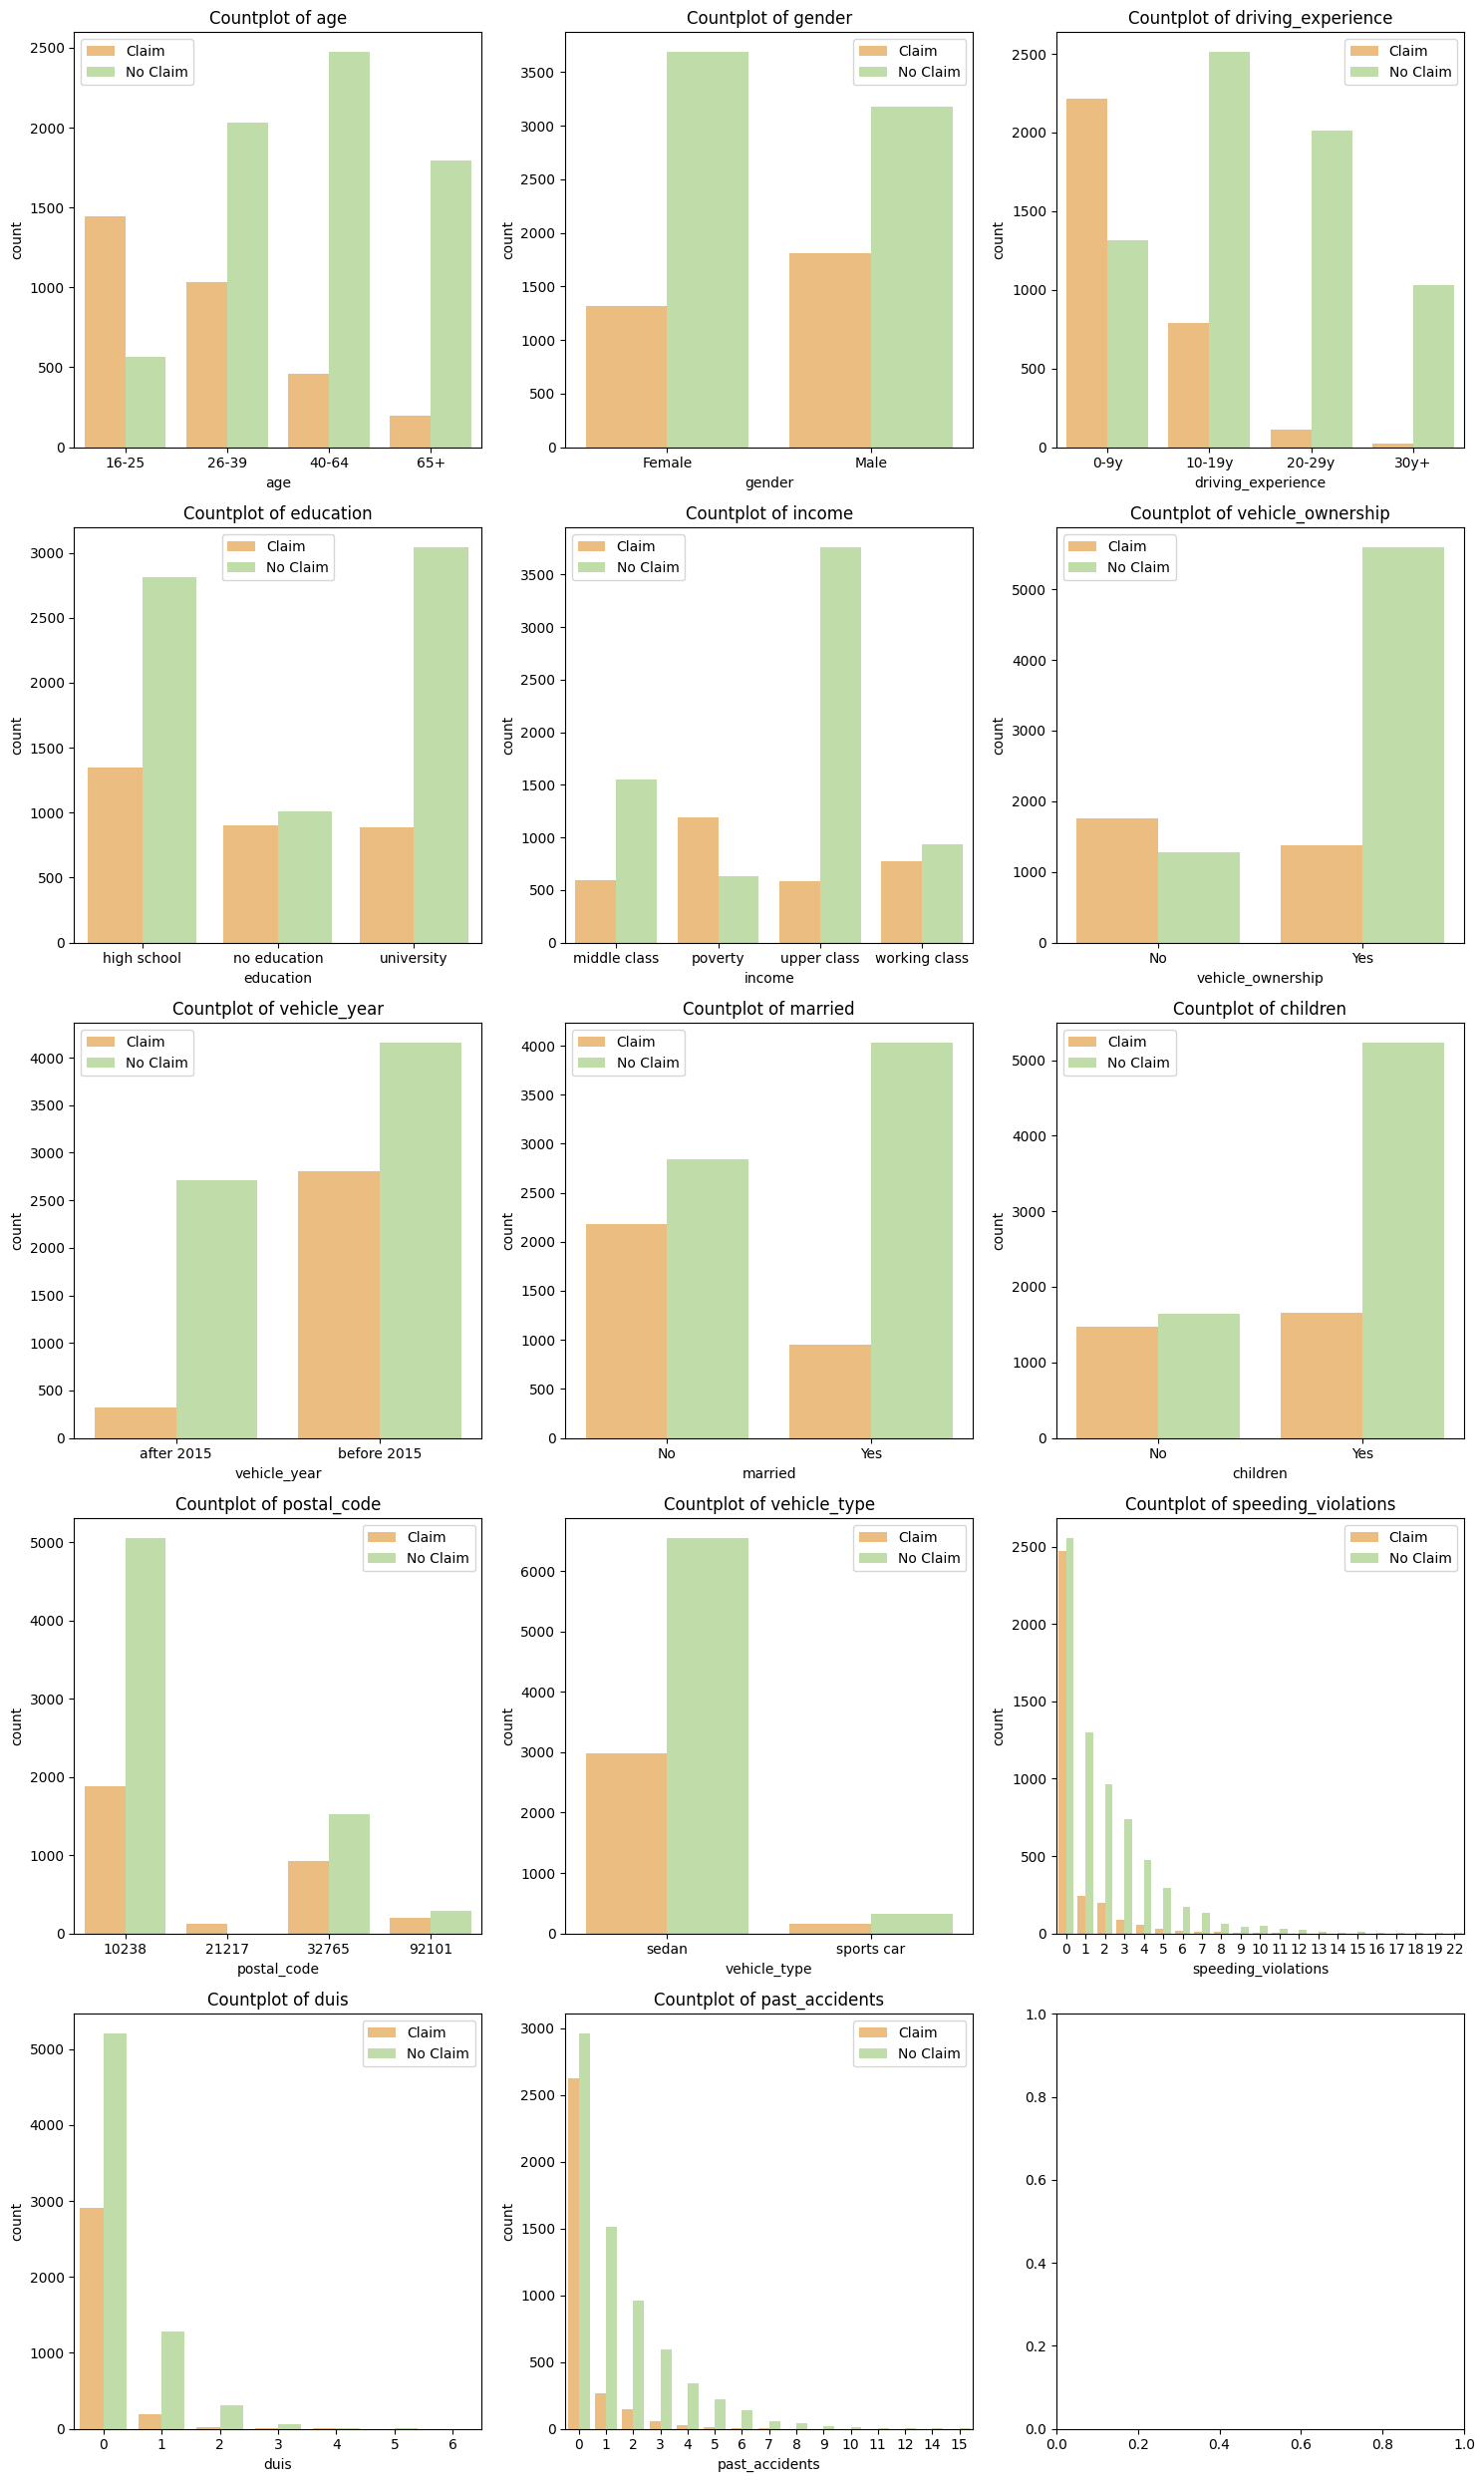

In [96]:
fig, axs = plt.subplots(5, 3, figsize = (15,  25))

# Plotting countplots for each categorical column
for i, col in enumerate(columns_to_plot[:-1]):  # Exclude 'outcome'
    row, col_index = divmod(i, 3)
    ax = axs[row, col_index]
    sns.countplot(x=col, hue='outcome', data=df, ax=ax, palette='Spectral')
    ax.set_title(f'Countplot of {col}')
    ax.legend(loc='best')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Here is a complete description of the information we can get from above plots.

### **1. AGE**
We can see that the customers in the age group of 40-64 have the highest ratio who have not claimed the insurance uptill now. While the age group 16-24 have the highest ratio who claimed the innsurance money. This means hat age is someho related to insurance claim.
### **2. GENDER**
In both genders, we have greater number of customers who have claimed the insurance. So we can conclude that the customers gender have no effect on the insurance claim.
### **3. DRIVING EXPERIENCE**
In this column we can see that the people who have a exoereince of 30+ years have never claimed any insurance. This may be due to the fact that there experince saves them from accidents and traffic rules violation. 

### **4. VEHICLE YEAR**
Cars bought after 2015 have low count for insurance claims, while the cars bought before 215 have higher ratio of claims.

### **5. INCOME**
In the income column we can see that the rich class has the highest ratio of customers who have not claimed the insurance money.

### **6. SPEEDING VIOLATIONS, DUIS AND PAST ACCIDENTS**
In these columns we can see that as the values increase the claim decrease, and similarly the customers who have not claimed also decresed.

## **Histograms of Numerical Features**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

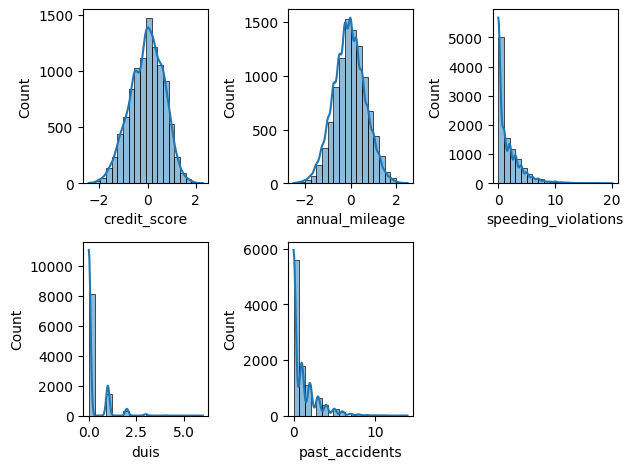

In [335]:
# List of numerical columns
columns = ['credit_score', 'annual_mileage', 'speeding_violations', 'duis', 'past_accidents']

# Create histograms for each numerical column
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], bins = 20, kde = True)
    plt.xlabel(column)
plt.tight_layout()
plt.show()

- The majority of the data points (the highest frequency) of the credit score are centered around a credit score of approximately 0.6, with fewer individuals having scores closer to 0.2 or 1.0.
- The distribution of the annual_mileage is relatively symmetric, with most customers driving between 7,500 and 17,500 miles annually.
- A normal distribution in these features indicates a balanced dataset, with most customers falling into the average range for both credit score and mileage.
- The speeding violations, duis and past accidents are riightly skewed which means that these are very rare scenarios.


## **Checking the interquartile range and outliers**
Now let's make box plots of the numerical columns to heck if we have nay outliers in the data.

/tmp/ipykernel_33/450886574.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, i + 1)
/tmp/ipykernel_33/450886574.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, i + 1)


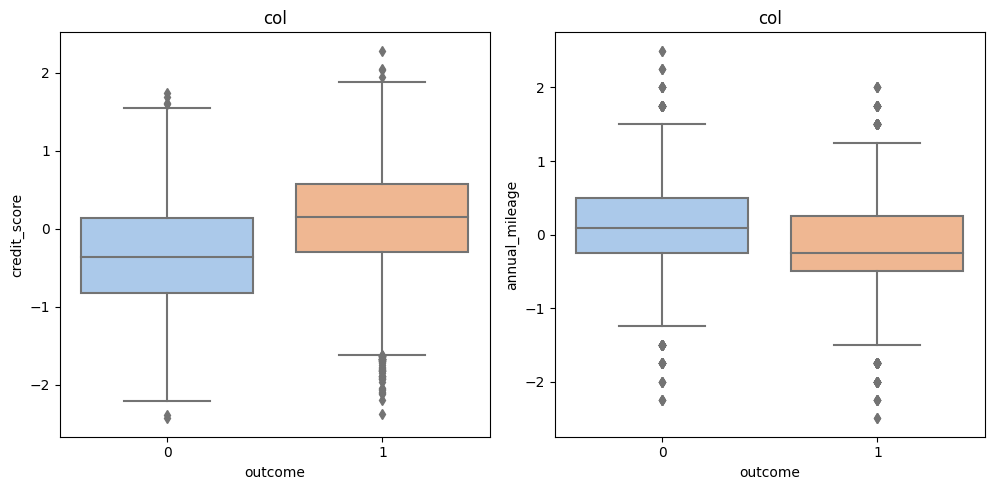

In [346]:
columns = ['credit_score', 'annual_mileage']
fig, axs = plt.subplots(1, 2, figsize = (15,  5))

for i, col in enumerate(columns):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x = 'outcome', y = col, data = df, palette = 'pastel')
    plt.title(f'col')

plt.tight_layout()
plt.show()

### **Credit Score**
- The "No Claim" median credit score is higher than that of "Claim" people. Consequently, those who have higher credit score are less likely to put in a claim.
- For "Claim" persons, the IQR, which is the box part of the plot, is wider than for "No Claim" individuals showing that there is more variability in credit scores among those who have filed claims compared to the "No Claim" group.
- The Claim group also has more outliers including some very low credit scores which might suggest that low credit scores could be linked with greater chances of making a claim.
### **Annual Mileage**
- The "Claim" group has average annual mileage that is slightly higher than "No Claim" group; hence they are almost equal. This may mean that those who drive more are slightly more likely to file a claim.
- Both groups have similar IQR suggesting that people who file claims do not differ too much in terms of their annual mileage.
- A few cases of high outliers were found within the “No Claim” category but on the other hand it was discovered that some customers with very high annual mileages never made any complaints at all. For claims, there are people with both low and high mileage suggesting therefore that even those individuals who drive very little or too excessively have also been making claims.

In [349]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


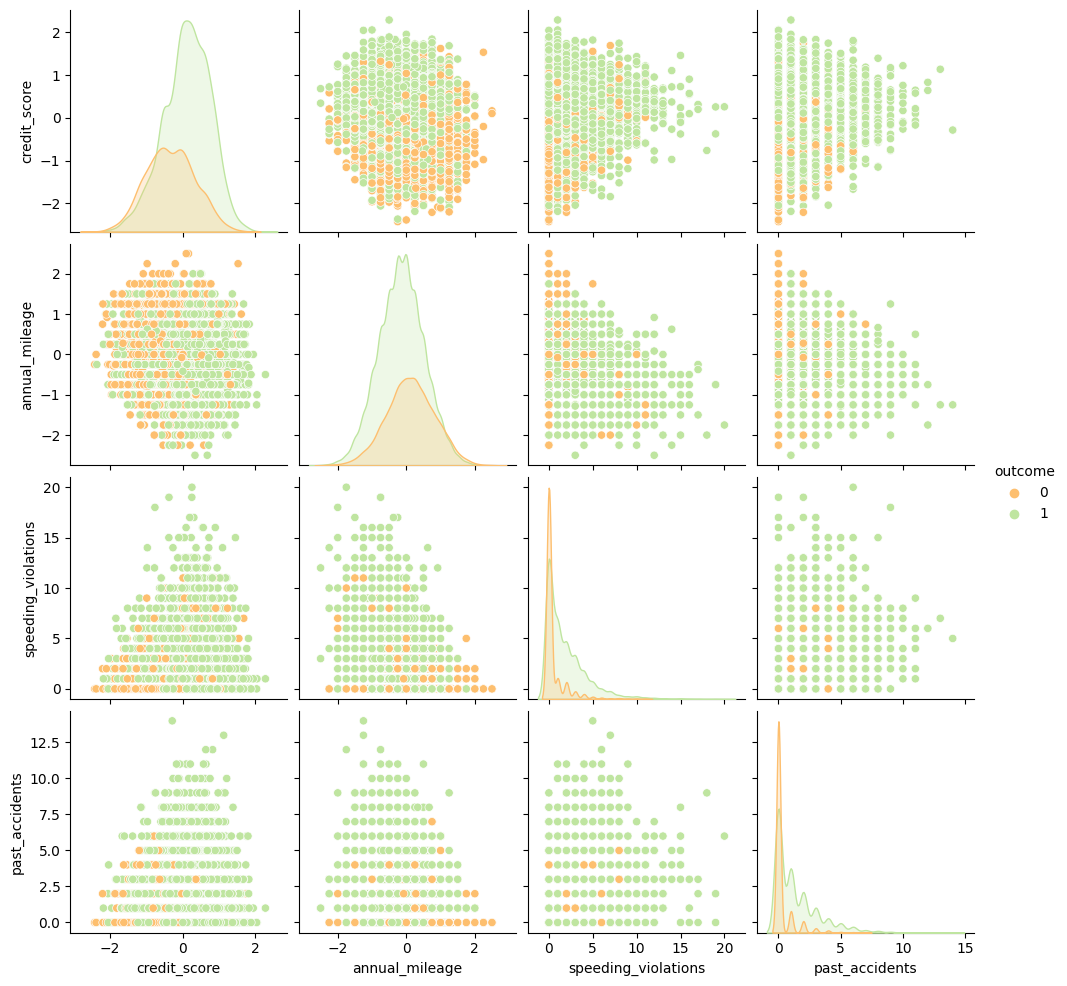

In [353]:
sns.pairplot(df[['credit_score', 'annual_mileage', 'outcome', 'speeding_violations', 
                 'past_accidents']], hue = 'outcome', palette = 'Spectral')
plt.show()


**Risk Indication of Credit Score**: The distribution and scatter diagram can suggest that the credit score may be a larger predictor of filing behavior rather than annual mileage.

**Overlapping Distributions**: The overlapping kind of the groups for “Claim” and “No Claim” data means that predicting claims only on these two could be difficult because they do not completely divide.

**Possible Interactions**: Considering the existing overlap, there can be other variables that are very important for determining claims. THE THE THE

In [100]:
df.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,65+,Female,0-9y,high school,upper class,0.629027,Yes,after 2015,No,Yes,10238,12000.0,sedan,0,0,0,No Claim
1,16-25,Male,0-9y,no education,poverty,0.357757,No,before 2015,No,No,10238,16000.0,sedan,0,0,0,Claim
2,16-25,Female,0-9y,high school,working class,0.493146,Yes,before 2015,No,No,10238,11000.0,sedan,0,0,0,No Claim
3,16-25,Male,0-9y,university,working class,0.206013,Yes,before 2015,No,Yes,32765,11000.0,sedan,0,0,0,No Claim
4,26-39,Male,10-19y,no education,working class,0.388366,Yes,before 2015,No,No,32765,12000.0,sedan,2,0,1,Claim


---
# **<div style="text-align: center; color: blue; font-size: 50px;">HYPOTHESIS TESTING</div>**
- Hypothesis testing is an important component of statistical analysis that helps us draw meaningful conclusions from the data. 

- In the case of car insurance, it may provide very valuable insights into the factors that affect insurance claims and driving behaviors. 

- The objective of the analysis is to test various hypotheses developed in relation to car insurance claims, based on the characteristics of policyholders. 

- In determining this, we will use variables that include driving experience, income level, postcode, and accident history to deduce whether these variables have a significant effect on the possibility of claiming insurance.

## **HYPOTHESIS 1: People who have experience of 30+ years have made less claims than other age groups.**

To test the hypothesis here is our null and alternative hypothesis:

**Null Hypothesis (H0):** There is no significant association between having 30+ years of driving experience and the likelihood of making an insurance claim.

**Alternative Hypothesis (H1):** People with 30+ years of driving experience have fewer insurance claims compared to those with less experience.

In [101]:
# Get the numeric outcome column
X = df['outcome'].apply(lambda x: 1 if x == 'Claim' else 0)

# Get the filtered column for driving expreince
Y = df['driving_experience'].apply(lambda x: '30+ years' if '30' in x else 'Less than 30 years')

In [102]:
# create a table for the above two columns
table = pd.crosstab(X, Y)
table

driving_experience,30+ years,Less than 30 years
outcome,,
1,20,3113
0,1032,5835


Now that we have grouped our data as we need for our hypothesis testing, we can perform chi square test on the data.

In [103]:
chi2, p_value, dof, expected = stats.chi2_contingency(table)

In [104]:
chi2, p_value, dof, expected

(471.7427645400213,
 1.338233477953918e-104,
 1,
 array([[ 329.5916, 2803.4084],
        [ 722.4084, 6144.5916]]))

From the above output we can see that `p_value` < 0.05 so we,

#### **Reject the null hypothesis: There is a significant association between having 30+ years of driving experience and having fewer insurance claims.**

This hypothesis also proves the claim that we made previously in the count plots.

## **HYPOTHESIS 2: People with less than 2 accidents have done less insurance claims than the customers who have more acccidents.**

**Null Hypothesis (H0):** There is no significant association between having fewer than 2 accidents and not making an insurance claim.

**Alternative Hypothesis (H1):** There is a significant association between having fewer than 2 accidents and not making an insurance claim.
Approach:

In [105]:
Y =  df['past_accidents'].apply(lambda x: 'Fewer than 2' if x < 2 else 'More than 2')

In [106]:
table = pd.crosstab(X, Y)
table

past_accidents,Fewer than 2,More than 2
outcome,,
1,2891,242
0,4476,2391


In [107]:
# Perform the Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(table)
chi2_stat, p_value, dof, expected

(812.8341626290465,
 8.744010251267029e-179,
 1,
 array([[2308.0811,  824.9189],
        [5058.9189, 1808.0811]]))

From the above output we can see that `p_value` < 0.05 so we,

#### **Reject the null hypothesis: There is a significant association between having fewer than 2 accidents and making an insurance claim.**

## **HYPOTHESIS 3: Do lower income (poverty class) people make insurance claim while other donot**

In [108]:
# Create a new column indicating whether the person is in the lower income group (poor) or not
Y = df['income'].apply(lambda x: 'Lower income' if x == 'poverty' else 'High Income')

In [109]:
# Create a contingency table for income group and claim outcome
table = pd.crosstab(X, Y)
table

income,High Income,Lower income
outcome,,
1,1947,1186
0,6239,628


In [110]:
# Perform the Chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(table)
chi2_stat, p_value, dof, expected

(1192.2806544286773,
 2.903573132064946e-261,
 1,
 array([[2564.6738,  568.3262],
        [5621.3262, 1245.6738]]))

From the above output we can see that p_value < 0.05 so we,

#### **Reject the null hypothesis: There is a significant association between having fewer than 2 accidents and making an insurance claim.**

---
# **<div style="text-align: center; color: blue; font-size: 50px;">FEATURE TRANSFORMATION</div>**
Now that we have done exploratory data analysis for our data we need to do some Feature engineering on our dataframe to make it prepare for model development.
The main steps in this section will include.
1. Scaling Numerical Data.
2. Encoding Categorical Variables
3. Dimensionality Reduction of DataFrame.

## **1. DATA SCALING**
- We already saw in our box plot that we have some outliers in our data.
- For this reason we are using Robust Scaler beacuse they are more robust to the outliers.

In [133]:
df.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,3,0,0,0,2,0.561777,1,0,0,1,0,0.00,0,0,0,0,1
1,0,1,0,1,1,-0.847305,0,1,0,0,0,1.00,0,0,0,0,0
2,0,0,0,0,3,-0.144044,1,1,0,0,0,-0.25,0,0,0,0,1
3,0,1,0,2,3,-1.635523,1,1,0,1,2,-0.25,0,0,0,0,1
4,1,1,1,1,3,-0.688311,1,1,0,0,2,0.00,0,2,0,1,0


In [111]:
numerical_columns = ['credit_score', 'annual_mileage', 'speeding_violations', 
                 'duis', 'past_accidents']

In [112]:
# Feature Scaling
scaler = RobustScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

Now our data has been scaled. Next we need to encode our categories.

## **2. ENCODING CATEGORICAL COLUMNS**
For encoding the categorical columns I am using te label enocde to encode the categories in the data.
Here is the code:

In [113]:
columns_to_encode = [
    'age', 'gender', 'driving_experience', 'education', 'income',
    'vehicle_ownership', 'vehicle_year', 'married', 'children',
    'postal_code', 'vehicle_type', 'speeding_violations', 'duis',
    'past_accidents', 'outcome'
]

In [114]:
# Encode categorical variables
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [115]:
df.head()

,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,3,0,0,0,2,0.561777,1,0,0,1,0,0.00,0,0,0,0,1
1,0,1,0,1,1,-0.847305,0,1,0,0,0,1.00,0,0,0,0,0
2,0,0,0,0,3,-0.144044,1,1,0,0,0,-0.25,0,0,0,0,1
3,0,1,0,2,3,-1.635523,1,1,0,1,2,-0.25,0,0,0,0,1
4,1,1,1,1,3,-0.688311,1,1,0,0,2,0.00,0,2,0,1,0


In [134]:
df.shape

(10000, 17)

Now we have done all the transformation on our data, all our data is in numerical form now. Now if we want to see the correlation between different features we can take the help of heatmap to quickly visualize how strongly different features are related to each other.

## **3. CHECKING CORRELATION BETWEEEN FEATURES**

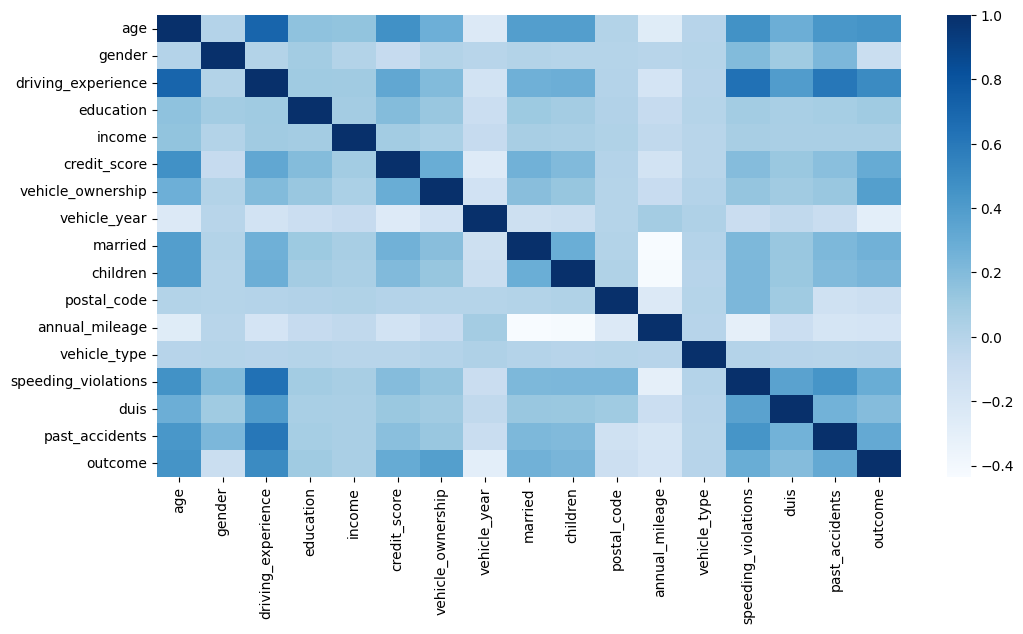

In [162]:
# Correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=False, cmap = 'Blues')
plt.show()

#### **Strong Correlations:**
- **Driving experience and age:** A strong positive correlation is expected because older people usually have more driving experience.
- **Vehicle year and vehicle ownership:** They have a mild positive correlation, implying that leasing or financing are less common in newer cars.
- **Annual mileage and vehicle type:** It means there is a mild positive correlation showing that some types of vehicles might be associated with higher miles driven per year.

#### **Negative Correlations:**
- **Past accidents and driving experience:** This suggests a negative relationship between the two variables since experienced drivers tend to have few past accidents.
- **Vehicle year and past accidents:** There appears to be a very slight negative relationship suggesting that newer vehicles may have fewer past accidents.
- **Income and duis (driving under influence):** This indicates a negative relationship where those with higher incomes may possess fewer DUIs.

#### **Outcome Variable:**
- The outcome variable, which represents insurance claims, has varying correlations with other features:
    - **Negative correlations:** These indicate less insurance claims as suggested by its association with prior collisions, speeding tickets and duis.
    - **Positive correlations:** These include more insurance claims such as seen when looking at credit score and income.

## **4. DIMENSIONALITY REDUCTION**
- From the abve plot we saw that there are some features that donot have a very strong impace on the target variable. Including these features in the model development can make our work more harder and will increase the complexity of our model and it may also effect our performance.
- A good pratice can be to reduce the dimensionality of our data and only keep the data that give us the maximum variance for the outcome varibale
- For this we can use Principal Component Analysis on our data.
- We will first fit the model on the our data and get the best number of features for our data. Then we will use those reduced features to train our model.

In [164]:
# Fit PCA
pca = PCA()
pca.fit(df.drop(columns = 'outcome'))

PCA()

After fitting the model we need to get the explained variance ratios for all the features in our dat. From these ratios we can get the best numer of features.

In [165]:
# Compute explained variance ratios
explained_variances = pca.explained_variance_ratio_
explained_variances

array([0.46575794, 0.14159468, 0.07875357, 0.06077062, 0.05578078,
       0.05025368, 0.03184991, 0.0225653 , 0.01756213, 0.0165603 ,
       0.0127597 , 0.01180389, 0.01102832, 0.01087437, 0.00907072,
       0.00301412])

In [167]:
# Compute cumulative explained variance
cumulative_explained_variances = explained_variances.cumsum()
cumulative_explained_variances

array([0.46575794, 0.60735262, 0.68610619, 0.7468768 , 0.80265758,
       0.85291126, 0.88476116, 0.90732646, 0.92488859, 0.94144889,
       0.95420858, 0.96601247, 0.97704079, 0.98791516, 0.99698588,
       1.        ])

- After calculating the cumulative_explained_variances we can get a better idea for our data.
- We can see that at he index 7 we have a value of 0.9073 which means that first 8 principal components together explain 90% of the variance in the dataset.
- This means that 8 components will be the best dimension fo rour data. We can get a better idea of the dimension by plotting the cumulative_explained_variances vs the number of components.

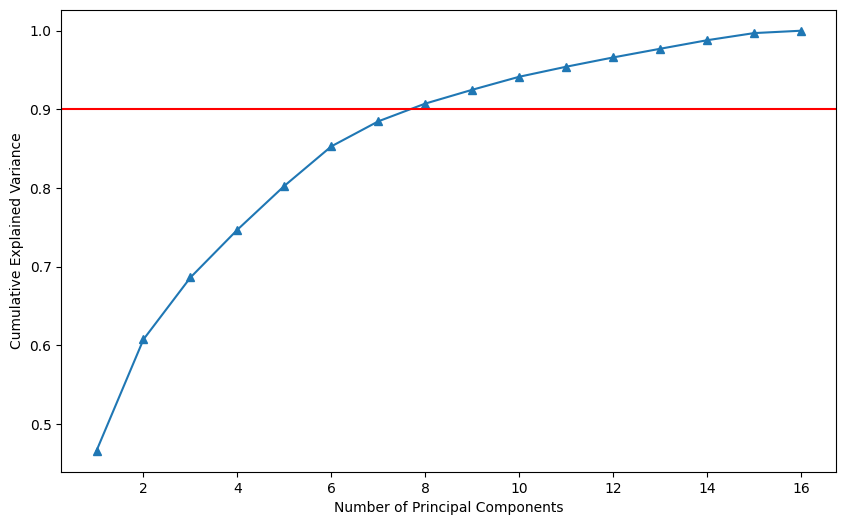

In [171]:
# Plot cumulative explained variance
plt.figure(figsize = (10, 6))
plt.plot(range(1, 17), cumulative_explained_variances, marker = '^')
plt.axhline(y = 0.90, color='r')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

The above model proves our previous claim that 8 componenets are best for our model. Now we will fit PCA on 8 components.

In [172]:
# Step 3: Dimensionality Reduction (PCA)
pca = PCA(n_components = 8)
X_pca = pca.fit_transform(df.drop(columns = ['outcome']))

In [176]:
X_pca.shape

(10000, 8)

Now we can see that the dimensionality of our data has been reduced to 8 which was previously 17.

Now the next part is model development.

---
# **<div style="text-align: center; color: blue; font-size: 50px;">PREPARE DATA FOR MODEL DEVELOPMENT</div>**


First we need to split our data in to features and target, As we know that our target column is the outcome colmn, while the features are the features obtained after PCA.

In [180]:
X = X_pca
y = df['outcome']

## **TRAIN-TEST SPLIT**
Next we need to split our data in to train and test sets, I am using 80 percent of data for trainig while rest of data for testing. We will also use the test set for our validation during training to overcome underfitting and overfitting.

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [182]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 8), (2000, 8), (8000,), (2000,))

---
# **<div style="text-align: center; color: blue; font-size: 50px;">MODEL DEVELOPMENT</div>**

- Let's develop and check different models of machine learning used for the insurance claim forecast depending on car insurance data. 
- The baseline models for this analysis are a set of commonly used and popular classifiers in scikit-learn: **Logistic Regression, Support Vector Classifier, Random Forest Classifier, and Decision Tree Classifier.**
- All models will be benchmarked against other algorithms on equal grounds to establish a performance comparison of each algorithm against our data set. 
- Thereafter, the more advanced mathematical tools of **Artificial Neural Networks and Convolutional Neural Networks** will be introduced to further stress the accuracy of the forecast. 
- Artificial Neural Networks and Convolutional Neural Networks are fairly good at capturing complex patterns as well as interactions within the data; hence, it could be more suitable to get better results in terms of accuracy or to get insights into the influences on insurance claims outcomes. 
- This way, we'd be in a position to deduce the best model that can be used in the prediction of insurance outcomes and the extraction of useful information out of it.

In [248]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


# **BASELINE CLASSIFIERS**
For baseline classifiers we will be using Logistic Regression, Support Vector Classifier and Decision Tree Classifier. We will analyze their results on the testing data after the training is done.

## **1. LOGISTIC REGRESSION**

              precision    recall  f1-score   support

           0       0.61      0.77      0.68       633
           1       0.88      0.77      0.82      1367

    accuracy                           0.77      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.79      0.77      0.77      2000

Accuracy is: 0.7685



<Figure size 800x600 with 0 Axes>

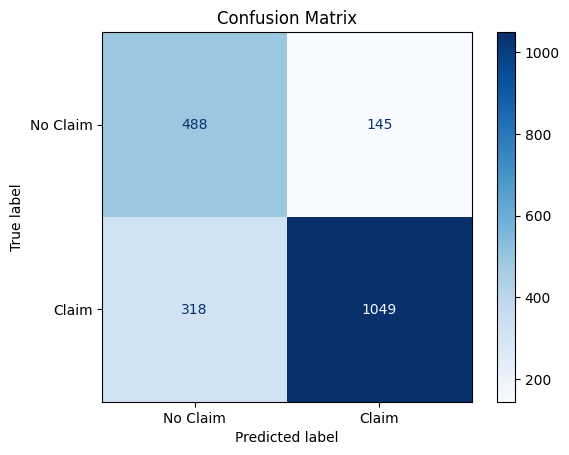

In [355]:
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
# Print the classification report and confusion matrix
print(classification_report(y_test, y_pred))    

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy is: {accuracy}\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- So if we talk about the model, it has a recall of only 0.77 which means it accurately identifies only half of all true claims.
- Furthermore, the precision shows that a claim is predicted correctly with 83% accuracy by this model.
- On the other hand for “No Claim” case lower precison have observed (0.63), this implies that it does not predicts many non-claims.
- In general the accuracy rates were measured at 76% which is too good but still required improvement in accurately identifying claims and distinguishing them from non-claims more effectively.

For further improvement we can do some hyper parameter tuning of our data, to see if we can improve our model.

In [202]:
# Define the parameter grid for Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],    
    'solver': ['liblinear', 'saga'] }

In [203]:
grid_search = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced'), param_grid = param_grid)

In [204]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [205]:
y_pred = best_model.predict(X_test)

Logistic Regression after Hyper Parameter Tuning Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.77      0.68       633
           1       0.88      0.77      0.82      1367

    accuracy                           0.77      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.79      0.77      0.77      2000

Accuracy: 0.767



<Figure size 800x600 with 0 Axes>

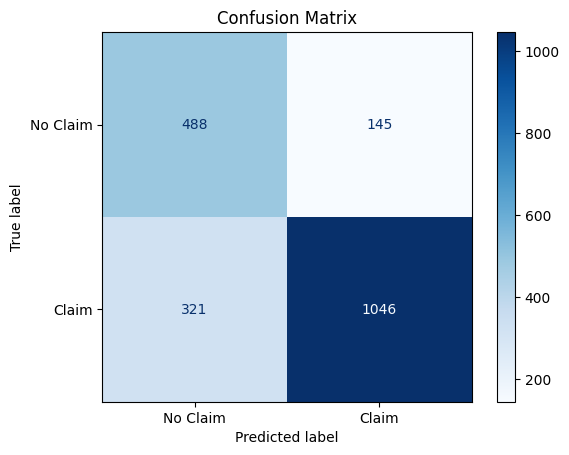

In [207]:
print(f'Logistic Regression after Hyper Parameter Tuning Classification Report:\n', classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}\n')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize =(8, 6))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Now we can see that our precision has been increased for the No claim target. Now we have 321 predictions for claim that are wrongly predicted as No Claim, Previously this number was 318.

## **2. SUPPORT VECTOR CLASSIFIER**

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.80      0.68       633
           1       0.89      0.75      0.81      1367

    accuracy                           0.76      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.80      0.76      0.77      2000

Accuracy: 0.764


<Figure size 800x600 with 0 Axes>

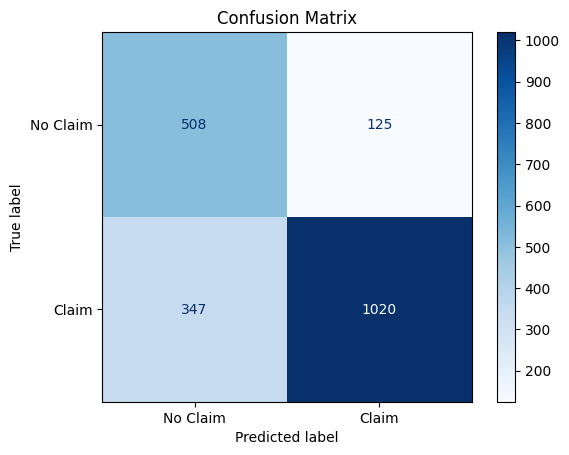

In [213]:
model = SVC(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
report = classification_report(y_test, y_pred)
# Print the classification report and confusion matrix
print(f'Classification Report:\n', classification_report(y_test, y_pred))    

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- For support vector classifier we are getting an accuracy of 76%.
- The true negative rate is high, which indicate that here are some entriess which are being predicted as No calim while the actual label is Claim.
- Overall the model performance is good but it can be made better by makibg the model balanced for the target column.

## **3. DECISION TREE CLASSIFIER**

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.56      0.57       633
           1       0.80      0.81      0.80      1367

    accuracy                           0.73      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.73      0.73      0.73      2000

Accuracy: 0.7315


<Figure size 800x600 with 0 Axes>

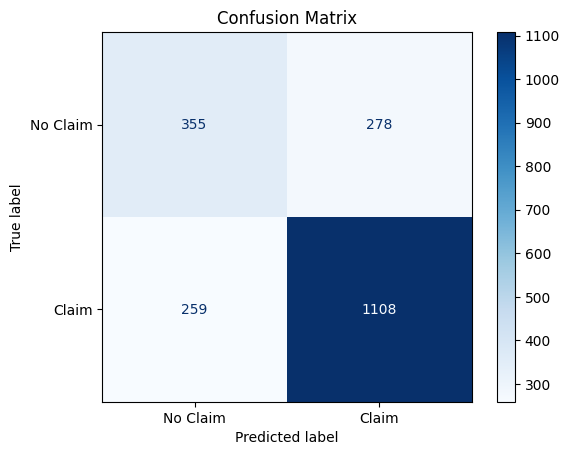

In [214]:
model = DecisionTreeClassifier(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
report = classification_report(y_test, y_pred)
# Print the classification report and confusion matrix
print(f'Classification Report:\n', classification_report(y_test, y_pred))    

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (8, 6))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Claim', 'Claim']).plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- It has a high precision of 0.89 in predicting claims, meaning that it is correct 89% of the time when it does predict a claim.
- It is seen that the recall for the "No Claim" label is higher, 0.80, compared to "Claim," which was 0.75; hence, the model is better in terms of diagnosing non-claims.
- The "Claim" F1-score was 0.81, compared with 0.68 for "No Claim", indicating a far more effective model in classifying claims.
- This model accuracy is 76.4%. While it's reasonable, it sits a bit below some of the others.

The SVC model does well on claims and has high precision with a solid recall for both classes. However, it misses a good fraction of claims, as seen from the 347 false negatives. It shows that the model has precision but may still need some tuning to improve recall in class "Claim" so that not many claims are missed. It helps when the model adjusts decision threshold or kernel parameters to have a better balancing of precision and recall.

# **ARTIFICIAL NEURAL NETWORK**
Below is the descirption of the ANN model that we wil use to train our data.

#### **Define the Model**
1. **Input Layer:**
`Dense(28, activation='relu', input_shape=(X_train.shape[1],))`: A dense (fully connected) layer with 28 neurons and ReLU activation function.
2. **Batch Normalization Layer:**
`BatchNormalization()`: This layer normalizes the output of the previous layer, which helps in stabilizing and speeding up the training process by reducing internal covariate shift.
3. **Dropout Layer:**
`Dropout(0.3)`: This helps in preventing overfitting by randomly setting 30% of the neurons in the previous layer to zero during each update.
4. **Output Layer:**
`Dense(1, activation='sigmoid')`: A dense layer with a single neuron and a sigmoid activation function. This layer is responsible for outputting the probability of the binary classification task.

In [320]:
ann_model = Sequential([
    # Input Layer
    Dense(28, activation='relu', input_shape = (X_train.shape[1],)), 
    BatchNormalization(),
    # Drop out to avoid overfitting
    Dropout(0.3),
    # Output Layer
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Compile the Model**
1. **Optimizer:**
`Adam(learning_rate=0.0006)`: The Adam optimizer is used with a learning rate of 0.0006, which adjusts the weights based on the gradients during backpropagation.
2. **Loss Function:**
`binary_crossentropy`: The binary cross-entropy loss function is used for binary classification problems, measuring the difference between predicted probabilities and actual class labels.
3. **Metrics:**
`accuracy`: Accuracy is used as a metric to evaluate the model's performance during training and validation.

In [321]:
# Compile the model with an optimizer, loss function, and metric
ann_model.compile(optimizer = Adam(learning_rate=0.0006), loss = 'binary_crossentropy', metrics = ['accuracy'])

#### **Fit the Model**
The model is trained using 200 epochs with a batch size of 32. The model performance is validate by test set.

In [322]:
history = ann_model.fit(X_train, y_train, epochs = 200,  batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6220 - loss: 0.6877 - val_accuracy: 0.7760 - val_loss: 0.4823
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7339 - loss: 0.5207 - val_accuracy: 0.7900 - val_loss: 0.4502
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7578 - loss: 0.4949 - val_accuracy: 0.7935 - val_loss: 0.4435
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7765 - loss: 0.4767 - val_accuracy: 0.7935 - val_loss: 0.4411
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7760 - loss: 0.4660 - val_accuracy: 0.7960 - val_loss: 0.4391
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7680 - loss: 0.4690 - val_accuracy: 0.7990 - val_loss: 0.4380
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7816 - loss: 0.4517 - val_accuracy: 0.8000 - val_loss: 0.4368
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7779 - loss: 0.4552 - val_accu

#### **Evaluate the model**
Now we will evaluate our model. First we wil get the accuracy and loss ofour model.

In [323]:
# Evaluate the model
loss, accuracy = ann_model.evaluate(X_test, y_test)
loss, accuracy

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8028 - loss: 0.4304


(0.4276066720485687, 0.800000011920929)

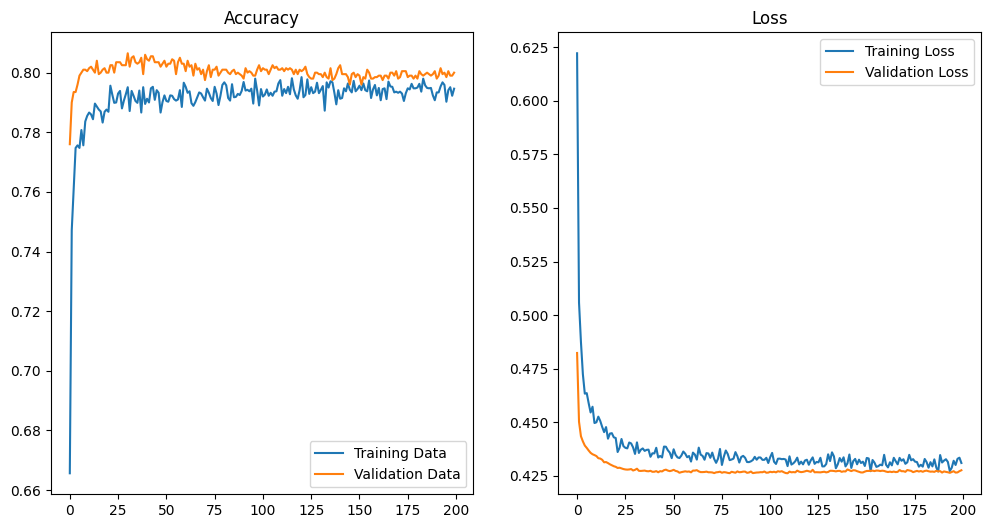

In [324]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Data')
plt.plot(history.history['val_accuracy'], label='Validation Data')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

The plot shows that our model has performed quite well.

**Accuracy**

The left graph shows the accuracy of the model on both the training and validation datasets. The blue line represents the training accuracy, starting just above 0.65 and gradually increasing to just below 0.80. The orange line represents the validation accuracy, starting around 0.70 and ending just above 0.75. Both lines fluctuate but show an overall upward trend, indicating that the model is learning and improving its accuracy over time.

**Loss**

The right graph depicts the loss values for both the training and validation datasets. The blue line indicates the training loss, which starts near 0.625 and decreases to close to 0.50. The orange line shows the validation loss, beginning around 0.675 and dropping sharply to just above 0.50 before flattening out. This downward trend in loss values suggests that the model is effectively minimizing errors during training.

In [325]:
# Predict the labels for the test set
y_pred = (ann_model.predict(X_test) > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the Accuracy and Loss Curves
plt.figure(figsize=(12, 6))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

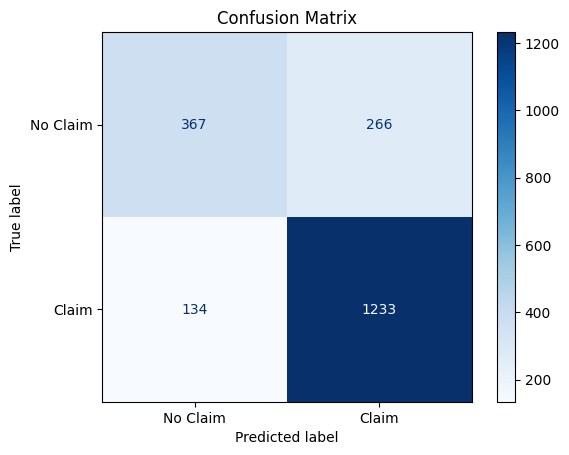

In [326]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Claim', 'Claim']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that you have an ANN model that is performing adequately. In fact, it correctly detected 1,233 customers who would buy insurance (True Positives) and 367 who wouldn’t (True Negatives). Nonetheless, there are still 266 cases in which the model wrongly predicted that customers would buy insurance (False Positives) and 134 instances in which it could not identify genuine buyers (False Negatives).

## **CONVOLUTIONAL NEURAL NETWORK**

In [312]:
# 1D Convolutional Model
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#### **Define the Model**
1. **Input Layer & Convolutional Block 1:**

    - `Conv1D` Layer: The first layer applies 32 convolutional filters, each with a size of 2, to the input data. The activation function used is ReLU ('relu'), which helps introduce non-linearity. The 'same' padding ensures that the output has the same length as the input.
    - `Input Shape`: The input shape is defined as (X_train_cnn.shape[1], 1), where X_train_cnn.shape[1] represents the number of features in the input data, and 1 represents a single channel.
    - `MaxPooling1D` Layer: This layer reduces the spatial size of the representation to decrease the computational cost and control overfitting. The pooling size is set to 2, which reduces the dimensionality by a factor of 2.
2. **Flatten Layer:** This layer flattens the 1D output from the convolutional layers into a 1D vector, preparing it for the fully connected layers.
3. **Fully Connected Layers:** Dense Layer (24 units): This layer has 24 neurons with ReLU activation, which further processes the flattened data.
4. **Dropout Layer (0.5):** Dropout is applied to reduce overfitting by randomly setting 50% of the input units to zero during training.
5. **Output Layer:** The final dense layer has 1 neuron with a sigmoid activation function, which outputs a probability for binary classification.

In [313]:
cnn_model = Sequential()

# Block 1
cnn_model.add(Conv1D(32, 2, activation='relu', padding='same', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())

cnn_model.add(Dense(24, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Compile the Model**
The model is compiled using the Adam optimizer, which adapts the learning rate during training. The loss function used is binary_crossentropy, appropriate for binary classification tasks. The metric being tracked during training is accuracy.

In [314]:
# Compile the model
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#### **Train the Model**
The model is trained for 100 epochs with a batch size of 32. The training data is passed to the model along with the validation data (X_test_cnn, y_test) to monitor the performance on unseen data during training.

In [315]:
# Train the model
history = cnn_model.fit(X_train_cnn, y_train, validation_data = (X_test_cnn, y_test), epochs = 100, batch_size = 32)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6424 - loss: 0.6186 - val_accuracy: 0.7930 - val_loss: 0.4753
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7728 - loss: 0.4853 - val_accuracy: 0.7995 - val_loss: 0.4519
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7784 - loss: 0.4762 - val_accuracy: 0.7950 - val_loss: 0.4469
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7861 - loss: 0.4677 - val_accuracy: 0.7960 - val_loss: 0.4419
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7862 - loss: 0.4606 - val_accuracy: 0.7900 - val_loss: 0.4396
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7869 - loss: 0.4588 - val_accuracy: 0.7920 - val_loss: 0.4404
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7833 - loss: 0.4561 - val_accuracy: 0.7990 - val_loss: 0.4359
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7792 - loss: 0.4642 - val_accu

#### **Model Evaluation**
Now we will evaluate our model. First we get the test accuracy and loss.

In [329]:
# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.4416


Our accuracy for test set is  which is quite good. Now let's plot the loss and accuracy curve to get a better idea of our model.

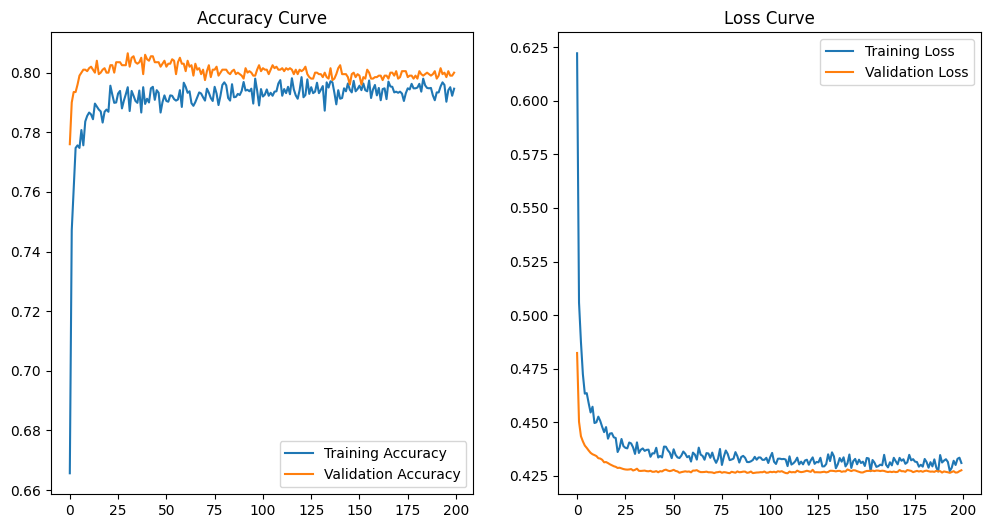

In [331]:
# Plotting the Accuracy and Loss Curves
plt.figure(figsize = (12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss Curve')
plt.legend()

plt.show()


**Training of model:** Model is development and enhancement of its functionality over time, as brought out by increasing precision and decreasing inaccuracy rates.
**Overfitting:** The gap in performance between the training phase and validation is very minimal signifying slight overfitting of the system. This implies that the model fits better to the training data than that which has not been seen before.

In [332]:
# Predict the labels for the test set
y_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 800x600 with 0 Axes>

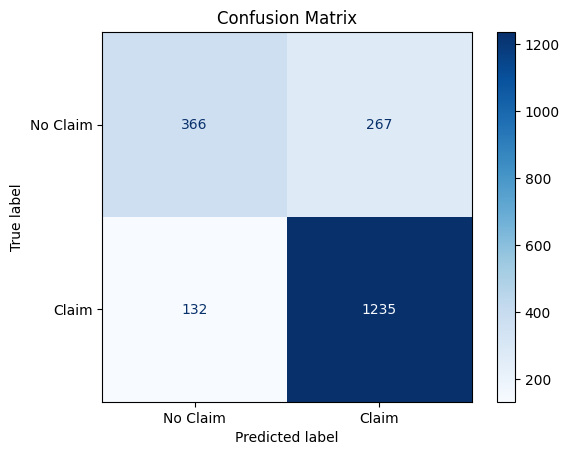

In [333]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Claim', 'Claim']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that your model performs well overall, with high accuracy, precision, and recall. However, there is room for improvement in reducing false positives and false negatives. Techniques such as adjusting the decision threshold, using more balanced training data, or applying different regularization methods might help improve these aspects.

---
# **<div style="text-align: center; color: blue; font-size: 50px;">CONCLUSION</div>**
The comprehensive exploratory data analysis (EDA) of the car insurance dataset has unveiled significant insights into the dataset's structure and feature relationships. 
- From EDA we gain insights on how different features have effect on our target variable. 
    - We studied that less income people are more likely to claim for an insurance. , while upper class has fewer frequncy for insurance claim.
    - Moreover, people with an experience of over 3o years have less acidents and traffic vilations, thus have less insurance claims.
    - People who have bought the car after 2015 are less likely to claim for an insurance.
    - From the count plots we gain insights on all the categorical column while pair plots helped us in gettin ginsights on the numerical columns.
    
- In the model development phase we have developed various models including ANN and CNN while we are getting an average accuracy of 80% which means our model is performing quite well.

- For urther improvement we can increase our data, and make it more balanced and robust.
- Moreover appling certain techniques like early stopping and minimizing learning rate can help us acheive a better accuracy,
    